In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

# Tensorflow uyarılarını engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Veri Analizi

In [31]:
df = pd.read_csv("TSLA.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [33]:
df["Date"] = pd.to_datetime(df["Date"])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2416 non-null   datetime64[ns]
 1   Open       2416 non-null   float64       
 2   High       2416 non-null   float64       
 3   Low        2416 non-null   float64       
 4   Close      2416 non-null   float64       
 5   Adj Close  2416 non-null   float64       
 6   Volume     2416 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.3 KB


In [35]:
tesla_df = df[["Date","Close"]]

In [36]:
tesla_df.index = tesla_df["Date"]

In [37]:
tesla_df.drop("Date", axis=1, inplace=True)

In [38]:
tesla_df.head()

,Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


In [39]:
tesla_copy = tesla_df.copy()

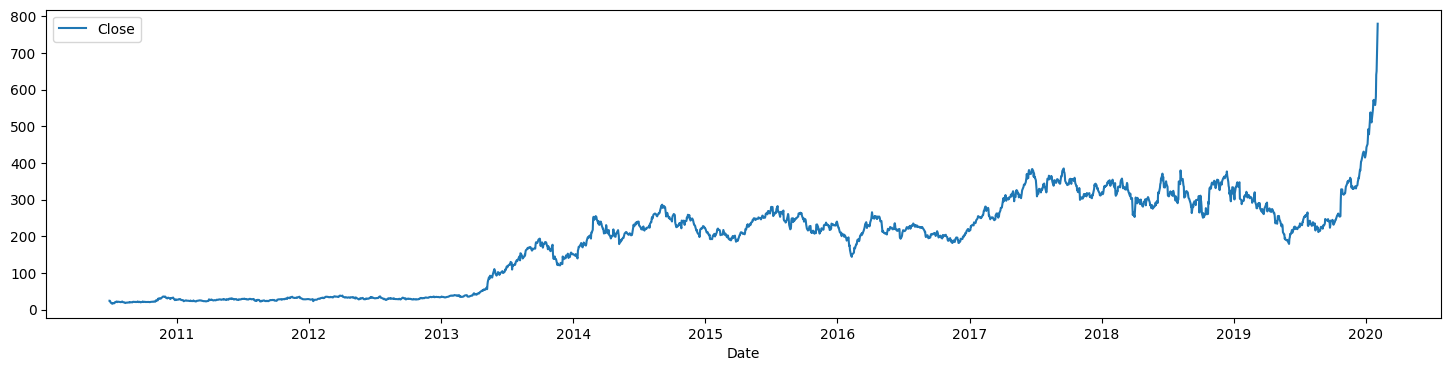

In [49]:
plt.figure(figsize=(18, 4))
sns.lineplot(tesla_df);

## Verinin Hazırlanması

In [104]:
data = tesla_df.values

In [105]:
data = data.astype("float32")

In [106]:
data[:5]

array([[23.89],
       [23.83],
       [21.96],
       [19.2 ],
       [16.11]], dtype=float32)

In [107]:
data = data.reshape(-1, 1)
data.shape

(2416, 1)

In [141]:
# eğitim ve test verilerini bölme
split = round(df.count().values[0] * 0.8)
train = data[:split]
test = data[split:]

In [142]:
train.shape, test.shape

((1933, 1), (483, 1))

In [143]:
# Verileri modelin daha iyi performans göstermesi için dönüştürme
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))
train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

In [151]:
# Verisetlerinin Hazırlanması
X_train = train.ravel()
y_train = train.ravel()[20:]

X_test = test.ravel()
y_test = test.ravel()[20:]

In [152]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1933,), (1913,), (483,), (463,))

In [153]:
def create_data(data, lookback):
    X = []
    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])

    return np.array(X)

In [154]:
lookback = 20
X_train = create_data(X_train, lookback)
X_test = create_data(X_test, lookback)

In [155]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1913, 20), (1913,), (463, 20), (463,))

In [156]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [157]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1913, 1, 20), (1913, 1), (463, 1, 20), (463, 1))

## LSTM Modelleme

In [212]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(.2))
model.add(Dense(1))

In [213]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 50)             14200     
                                                                 
 dropout_9 (Dropout)         (None, 1, 50)             0         
                                                                 
 dense_9 (Dense)             (None, 1, 1)              51        
                                                                 
Total params: 14251 (55.67 KB)
Trainable params: 14251 (55.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [214]:
# Optimizasyon ve Değerlendirme Metriklerini Ayarlama
model.compile(loss="mean_squared_error", optimizer="adam")

In [215]:
callbacks = [EarlyStopping(monitor="val_loss", patience=3, mode="min", verbose=1),
            ModelCheckpoint(filepath="TSLA.h5", monitor="val_accuracy", mode="max", 
                            verbose=1, save_best_only=True, save_weights_only=False)]

In [216]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 20,
    epochs = 100,
    callbacks = callbacks,
    validation_data=(X_test, y_test),
    shuffle = False,
    verbose = 1
)

Epoch 1/100
96/96 [==============================] - 2s 5ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/

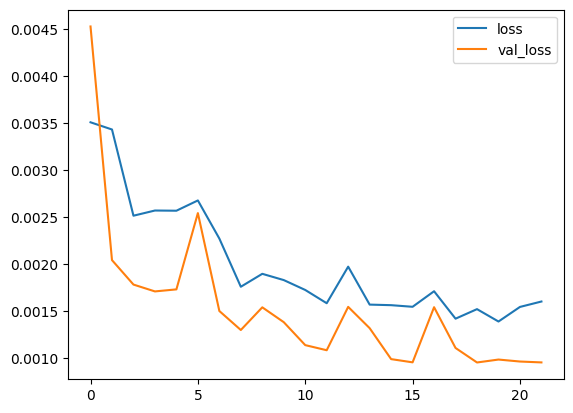

In [217]:
# Kayıp (maliyet) grafiği
loss = pd.DataFrame(history.history)
loss.plot();

In [218]:
pred = model.evaluate(X_test, y_test, batch_size=20)
print(f"Hata: %{pred*100:.2f}")

24/24 [==============================] - 0s 957us/step - loss: 9.5806e-04
Hata: %0.10


In [222]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

15/15 [==============================] - 0s 1ms/step


In [223]:
train_pred = train_pred.reshape(train_pred.shape[0], 1)
test_pred = test_pred.reshape(test_pred.shape[0], 1)

In [224]:
# Dönüştürülen verileri eski hallerine getirme
train_pred = scaler_train.inverse_transform(train_pred)
test_pred = scaler_test.inverse_transform(test_pred)

In [225]:
# Dönüştürülen verileri eski hallerine getirme
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [227]:
# Hataların hesaplanması
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Eğitim Hatası: {train_rmse:.2f}")
print(f"Test Hatası: {test_rmse:.2f}")

Eğitim Hatası: 9.48
Test Hatası: 18.60


In [228]:
# Eğitim ve Test tahminlerinin gerçek veri ile karşılaştırılması
train_pred_df = tesla_copy[lookback:split]
train_pred_df["Predicted"] = train_pred
train_pred_df.head()

,Close,Predicted
Date,,
2010-07-28,20.719999,15.020873
2010-07-29,20.350000,14.845696
2010-07-30,19.940001,14.780396
2010-08-02,20.920000,14.737155
2010-08-03,21.950001,15.026099


In [229]:
test_pred_df = tesla_copy[lookback+split:]
test_pred_df["Predicted"] = test_pred
test_pred_df.head()

,Close,Predicted
Date,,
2018-04-03,267.529999,276.139069
2018-04-04,286.940002,271.892212
2018-04-05,305.720001,274.895416
2018-04-06,299.299988,280.114532
2018-04-09,289.660004,283.579041


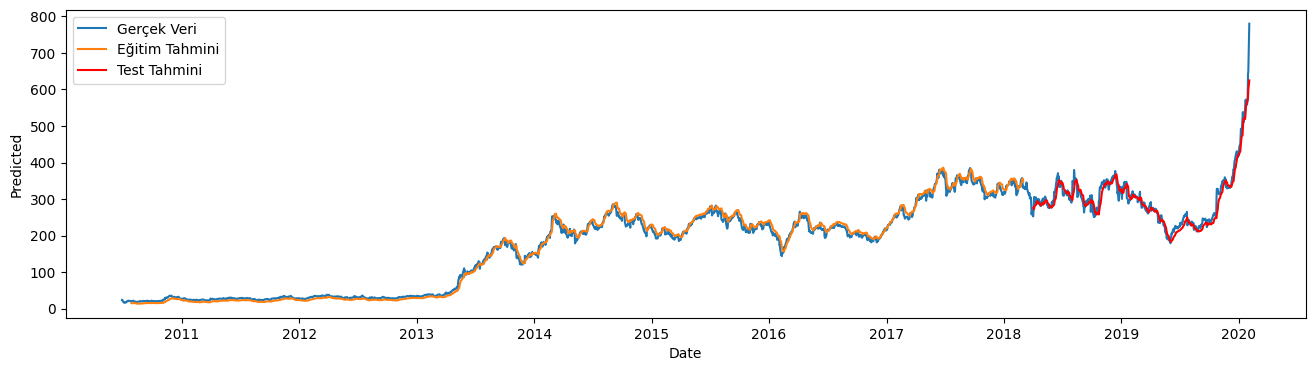

In [236]:
plt.figure(figsize=(16, 4))
sns.lineplot(tesla_copy, label="Gerçek Veri", legend=None)
sns.lineplot(train_pred_df["Predicted"], label="Eğitim Tahmini")
sns.lineplot(test_pred_df["Predicted"], label="Test Tahmini", color="red");

In [237]:
model.save("TSLA.h5")